In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import itertools
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import sklearn.neighbors
import torch
import tqdm

import celltrip

os.environ['AWS_PROFILE'] = 'waisman-admin'
mpl.rcParams['pdf.fonttype'] = mpl.rcParams['ps.fonttype'] = 42
sns.set_theme(context='paper', style='darkgrid', palette='colorblind')


# Load Steady States

In [3]:
methods = ['Observed', 'CellTRIP', 'MLP', 'KNN']
method_colors = {'Observed': 'black', 'CellTRIP': 'blue', 'MLP': 'green', 'KNN': 'red'}
development = np.array(['E14-16h_a', 'E16-18h_a', 'L1_a', 'L2_a', 'L3_b'])
development_colors = {dev: c for dev, c in zip(development, sns.color_palette('husl', len(development)))}
# holdout_development = np.array(['E14-16h_a', 'L2_a'])
cell_types = np.array([
    'CNS', 'amnioserosa', 'carcass', 'epidermis', 'epidermis/CNS',
    'fat body', 'fat body/trachea', 'foregut', 'foregut/garland cells',
    'hemolymph', 'hindgut', 'hindgut/malpighian tubule', 'midgut',
    'midgut/malpighian tubules', 'muscle', 'salivary gland', 'testis',
    'trachea'])  # np.unique(np.concat([points['Observed'][dev]['meta']['annotation'].unique() for dev in development]))
cell_type_colors = {ct: c for ct, c in zip(cell_types, sns.color_palette('colorblind', len(cell_types)))}


In [4]:
points = {}
for method, dev in itertools.product(methods[1:], development):
    # Initialize
    if method not in points: points[method] = {}
    if dev not in points[method]: points[method][dev] = {}
    # Load imputed
    points[method][dev]['gex'] = None
    points[method][dev]['obs'] = np.load(f'../plots/flysta/{method}_{dev}.npy')
    if methods[0] in points and dev in points[methods[0]]:
        points[method][dev]['meta'] = points[methods[0]][dev]['meta']
    else: points[method][dev]['meta'] = pd.read_csv(f'../plots/flysta/meta_{dev}.csv', index_col=None)
    # Save observed
    if methods[0] not in points: points[methods[0]] = {}
    if dev not in points[methods[0]]:
        points[methods[0]][dev] = {}
        points[methods[0]][dev]['gex'] = None
        points[methods[0]][dev]['obs'] = np.load(f'../plots/flysta/spatial_{dev}.npy')
        points[methods[0]][dev]['meta'] = points[method][dev]['meta']


In [5]:
# Print validation
holdout_development = []
for dev in development:
    num_val = points['Observed'][dev]['meta']['Training']
    if num_val.all(): stage_class = 'Training'
    elif num_val.any(): stage_class = 'Mixed'
    else:
        stage_class = 'Validation'
        holdout_development.append(dev)
    print(f'{dev}: {stage_class}')


E14-16h_a: Training
E16-18h_a: Validation
L1_a: Training
L2_a: Training
L3_b: Training


# Visualize

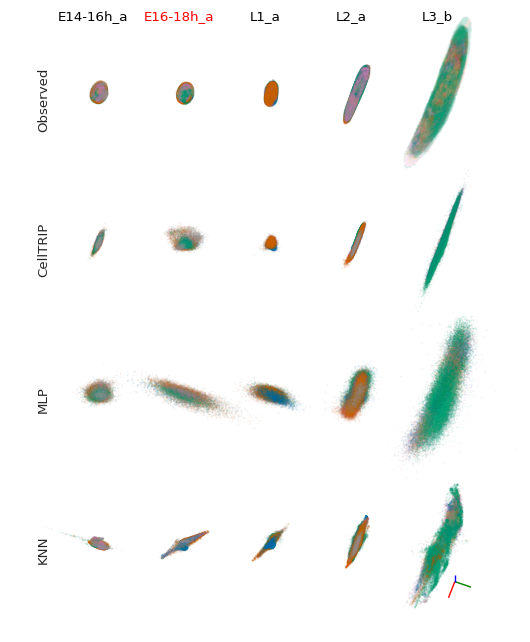

In [ ]:
# Create figure
fig, axs = plt.subplots(len(methods), len(development), subplot_kw={'projection': '3d'}, figsize=(2*len(development), 2*len(methods)))

# Data
camera_kwargs = {'elev': 70, 'azim': 20}
pca_class = {dev: sklearn.decomposition.PCA().fit(points['Observed'][dev]['obs']) for dev in development}
for ax, (method, dev) in zip(axs.flatten(), itertools.product(methods, development)):
    # Share axes
    reference = 0  # All same scale
    # reference = np.argwhere(np.array(development)==dev)[0, 0]  # Development same scale
    if ax != axs.flatten()[reference]:
        ax.sharex(axs.flatten()[reference])
        ax.sharey(axs.flatten()[reference])
        ax.sharez(axs.flatten()[reference])

    # Get data
    data = points[method][dev]['obs']
    data_types = points['Observed'][dev]['meta']['annotation']
    # sub_idx = np.random.choice(data.shape[0], 5_000, replace=False)  # Subsample for speed, only for testing
    # data = data[sub_idx]  # TESTING
    # data_types = data_types.iloc[sub_idx]  # TESTING
    data = celltrip.utility.general.transform_and_center(data, pca_class[dev])
    for ct in cell_types:
        # Plot
        data_filt = data[data_types==ct]
        # data_filt = data_filt[np.abs(data_filt[:, 2] - 0) < .5]  # Z-filtering
        ax.scatter(*data_filt.T, color=cell_type_colors[ct], alpha=.1, label=ct, s=.1)
        ax.set_aspect('equal')

        # Adjust axes
        for i, axis in enumerate((ax.xaxis, ax.yaxis, ax.zaxis)):
            # Adjust ticker
            axis.set_major_locator(mpl.ticker.MultipleLocator(base=10.))
            # Remove labels
            axis.set_ticklabels([])
            # Remove small tick lines
            axis._axinfo['tick']['inward_factor'] = 0.
            axis._axinfo['tick']['outward_factor'] = 0.
            # Remove all faces and ticks
            axis.set_ticks([])
            axis.set_pane_color((1., 1., 1., 0.))
            axis.line.set_color((1., 1., 1., 0.))
        
        # Camera location
        ax.view_init(**camera_kwargs)  # YX Plane, slightly offset
        # Transparent background
        ax.set_facecolor('none')

# Super labels
for ax, method in zip(axs[:, 0], methods): ax.text2D(.2, .5, method, rotation=90, ha='center', va='center', fontsize='medium', transform=ax.transAxes)
for ax, dev in zip(axs[0], development):
    ax.text2D(.5, 1., dev, rotation=0, ha='center', va='center', color='red' if dev in holdout_development else 'black', fontsize='medium', transform=ax.transAxes)

# Orientation indicator
# ax = axs[0][0].inset_axes((.2, .75, .2, .2), projection='3d')
ax = axs[-1][-1].inset_axes((.5, .2, .2, .2), projection='3d')
ax.set_facecolor('none')
for i, axis in enumerate((ax.xaxis, ax.yaxis, ax.zaxis)):
    # Remove labels
    axis.set_ticklabels([])
    # Remove small tick lines
    axis._axinfo['tick']['inward_factor'] = 0.
    axis._axinfo['tick']['outward_factor'] = 0.
    # Remove all faces and ticks
    axis.set_ticks([])
    axis.set_pane_color((1., 1., 1., 0.))
    axis.line.set_color((1., 1., 1., 0.))
ax.grid(False)
ax.quiver(0, 0, 0, 1, 0, 0, length=.1, arrow_length_ratio=0., lw=1., color='red', zorder=1)
ax.quiver(0, 0, 0, 0, 1, 0, length=.1, arrow_length_ratio=0., lw=1., color='green', zorder=1)
ax.quiver(0, 0, 0, 0, 0, 1, length=.1, arrow_length_ratio=0., lw=1., color='blue', zorder=1)
ax.view_init(**camera_kwargs)
ax.set_aspect('equal')

# Closer together
fig.subplots_adjust(wspace=-.8, hspace=-.1)
# fig.show()
fig.savefig('../plots/flysta/prediction_visualizations.pdf', transparent=True, bbox_inches='tight')


# Performance

In [ ]:
# Clustering performance
classification_performance = []
for dev in development:
    # Train classifier
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=200)
    y_true = points['Observed'][dev]['meta']['annotation'].to_numpy()
    knn.fit(points['Observed'][dev]['obs'], y_true)
    for method in methods:
        # Predict on imputed data
        if method == 'Observed': continue
        pred = knn.predict(points[method][dev]['obs'])
        for ct in cell_types.tolist()+['All']:
            if ct == 'All': subset_idx = slice(None)
            else:
                subset_idx = np.argwhere(y_true==ct).flatten()
                if len(subset_idx) == 0: continue
            knn_acc = (y_true[subset_idx] == pred[subset_idx]).mean()
            mse = np.square(points['Observed'][dev]['obs'][subset_idx] - points[method][dev]['obs'][subset_idx]).mean()
            classification_performance.append({
                'Method': method, 'Development': dev, 'Cell Type': ct, 'KNN Accuracy': knn_acc, 'MSE': mse})
classification_performance = pd.DataFrame(classification_performance)


/tmp/ipykernel_511050/1603041009.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_specific['y'] = df_specific['Cell Type'].apply(lambda s: {l: float(i) for i, l in enumerate(yticklabels)}[s])


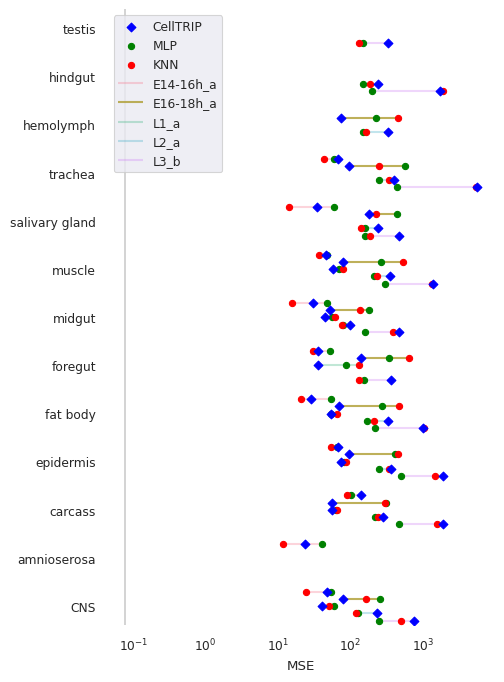

In [77]:
# Params
# statistic = 'KNN Accuracy'
# xlog = False
statistic = 'MSE'
xlog = True

# Plot
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 1, figsize=(5, 8))
if xlog: ax.set_xscale('log')

# Prepare data
df = classification_performance.copy()
df = df.loc[df['Cell Type'].apply(lambda s: '/' not in s)]  # NOTE: Just drops these, but doesn't in the 'All' calculation
# df = df.loc[df['Development'].isin(holdout_development)]  # Only show holdouts
df_all = df.loc[df['Cell Type']=='All']
df_specific = df.loc[df['Cell Type']!='All']

# Set ticks
yticklabels = df_specific['Cell Type'].unique()
ax.set(
    yticks=range(len(yticklabels)),
    yticklabels=yticklabels)

# Set comparison point
midpoint = 1. / len(yticklabels)  # df_all['Accuracy'].mean()

# Apply offsets
offset = .3
development_offsets = -np.linspace(-offset, offset, len(df_specific['Development'].unique()))
df_specific['y'] = df_specific['Cell Type'].apply(lambda s: {l: float(i) for i, l in enumerate(yticklabels)}[s])
for i, dev in enumerate(df_specific['Development'].unique()):
    # Offset
    df_specific.loc[df_specific['Development']==dev, 'y'] += development_offsets[i]
    
# Plot by method
for method in methods:
    if method == 'Observed': continue
    df_filt = df_specific.loc[df_specific['Method']==method]
    ax.scatter(
        df_filt[statistic], df_filt['y'],
        color=method_colors[method], marker='D' if method == 'CellTRIP' else 'o',
        s=20., label=method, zorder=10 if method=='CellTRIP' else 2)

# Draw lines
df_group = df_specific.groupby(['Cell Type', 'Development']).agg({'y': 'first', statistic: ['min', 'max']}).reset_index()
ax.axvline(x=midpoint, color='gray', alpha=.4, zorder=.9)
for dev in df_specific['Development'].unique():
    df_filt = df_group.loc[df_group['Development']==dev]
    ax.hlines(
        df_filt['y']['first'],
        df_filt[statistic]['min'],
        df_filt[statistic]['max'],
        # np.minimum(midpoint, df_filt[statistic]['min']),
        # np.maximum(midpoint, df_filt[statistic]['max']),
        color=development_colors[dev], alpha=.8 if dev in holdout_development else .3, lw=1.5, label=dev, zorder=.8)

# Format
ax.set_xlabel(statistic)
ax.set_ylim(-offset-.1, len(yticklabels)-1+offset+.1)
sns.despine(ax=ax, left=True, bottom=True)
ax.legend()
# fig.show()
fig.savefig('../plots/flysta/prediction_classification_performance.pdf', transparent=True, bbox_inches='tight')


# Interpolation

In [92]:
# Load transition data
idx = np.argwhere(development==holdout_development[-1])[0, 0]
sequence_dev = development[idx-1:idx+2]
transition = np.load(f'../plots/flysta/Interpolated_{sequence_dev[1]}.npy')
data = transition[[0, 4, -1]]  # Takes first, last, and 200

# Orient the data
_, pca = celltrip.utility.general.transform_and_center(transition[-1], return_pca=True)
data = pca.transform(data.reshape((-1, data.shape[-1]))).reshape(data.shape)

# Compute error
pred_mse = -1  # TODO
# pred_mse = np.square(
#     celltrip.utility.general.transform_and_center(points['Observed'][sequence_dev[1]]['obs'])
#     - celltrip.utility.general.transform_and_center(data[1])
# ).mean()

# Infer types (TODO: Revise this or justify, this seems like cheating)
types = []
_, types_pca = celltrip.utility.general.transform_and_center(points['Observed'][sequence_dev[-1]]['obs'], return_pca=True)
for i, dev in enumerate(sequence_dev):
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10).fit(types_pca.transform(points['Observed'][dev]['obs']), points['Observed'][dev]['meta']['annotation'])
    types.append(knn.predict(data[i]))

# Offset the data
spread = 50
data_offsets = -np.linspace(-spread, spread, data.shape[0])  # Offset earlier development higher
data[..., -1] += data_offsets.reshape((data.shape[0], 1))

/tmp/ipykernel_511050/3612265706.py:62: RuntimeWarning: invalid value encountered in sqrt
  ax.get_xlim()[1]-2, ax.get_ylim()[0]+2, ax.get_zlim()[1]-2, f'RMSE: {np.sqrt(pred_mse):.3f}',


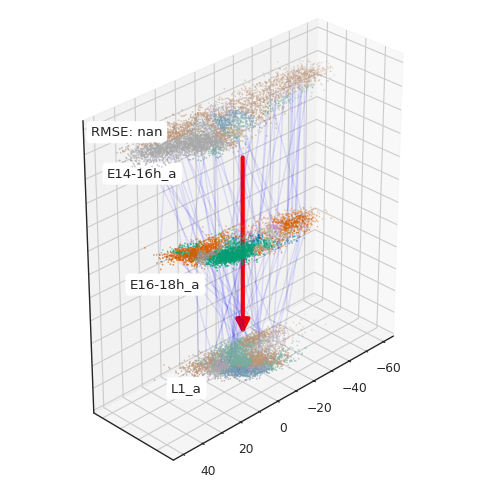

In [105]:
# Arrow3D (https://stackoverflow.com/a/22867877)
class Arrow3D(mpl.patches.FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = mpl_toolkits.mplot3d.proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

# Plot
fig = plt.figure(figsize=(6, 6))
with sns.axes_style('white'):
    ax = fig.add_subplot(111, projection='3d')
# Main plot
for ct, (i, dev) in itertools.product(cell_types, enumerate(sequence_dev)):
    color = np.array(cell_type_colors[ct])
    if dev != sequence_dev[1]:
        color = (1/3)*color + (2/3)*np.array(3*[.7])
    ax.scatter(
        *data[i][types[i]==ct].T,
        color=color,
        # alpha=.5 if dev != intermediate_dev else 1.,
        s=.1, label=ct)
# Development quivers
arrow = Arrow3D(
    (0, 0), (0, 0), (.8*data[:, -1].max(), .8*data[:, -1].min()),
    lw=3, mutation_scale=20, arrowstyle='-|>', color='red')
ax.add_artist(arrow)
# OT lines
num_lines = 50
for i in range(len(sequence_dev)-1):
    pairs = np.random.choice(data.shape[1], num_lines, replace=False)
    pair_coords = np.stack([data[i, pairs], data[i+1, pairs]], axis=1)
    for coords in pair_coords:
        ax.plot(*coords.T, lw=1., alpha=.1, color='blue')
# Modify ticks
for i, axis in enumerate((ax.xaxis, ax.yaxis, ax.zaxis)):
    # Adjust ticker
    axis.set_major_locator(mpl.ticker.MultipleLocator(base=20.))
    axis.set_minor_locator(mpl.ticker.MultipleLocator(base=10.))
    if i != 0:
        # Remove labels
        axis.set_ticklabels([])
        # Remove small tick lines
        axis._axinfo['tick']['inward_factor'] = 0.
        axis._axinfo['tick']['outward_factor'] = 0.
# Annotations
ax.text3D(
    50, 0, data_offsets[0], sequence_dev[0], ha='center', va='center', fontsize='medium',
    bbox=dict(facecolor='white', boxstyle='round'), zorder=50)
ax.text3D(
    40, 0, data_offsets[1], sequence_dev[1], ha='center', va='center', fontsize='medium',
    bbox=dict(facecolor='white', boxstyle='round'), zorder=50)
ax.text3D(
    30, 0, data_offsets[2], sequence_dev[-1], ha='center', va='center', fontsize='medium',
    bbox=dict(facecolor='white', boxstyle='round'), zorder=50)
ax.text3D(
    ax.get_xlim()[1]-2, ax.get_ylim()[0]+2, ax.get_zlim()[1]-2, f'RMSE: {np.sqrt(pred_mse):.3f}',
    ha='left', va='top', fontsize='medium', bbox=dict(facecolor='white', boxstyle='round'), zorder=50)
# Formatting
ax.view_init(elev=30, azim=45)
ax.set_aspect('equal')
# fig.show()
fig.savefig('../plots/flysta/interpolation_visualization.pdf', transparent=True, bbox_inches='tight')


# Knockdown

In [ ]:
# Load knockdown data
# TODO: Determine significance
knockdown_significance = pd.read_csv('../plots/flysta/knockdown.csv', index_col=None)


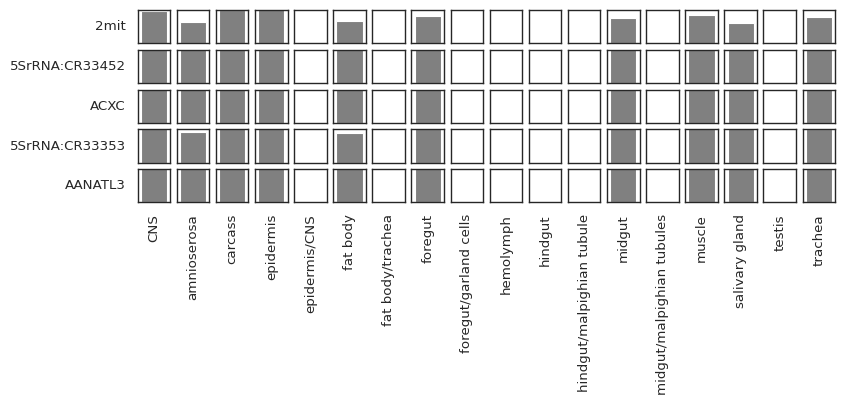

In [15]:
# Parameters
statistic = 'Effect Size'

# Create figure
num_genes = 5
fig = plt.figure(figsize=(.5*len(cell_types), .5*num_genes))
with sns.axes_style('white'):
    axs = fig.subplots(num_genes, len(cell_types), sharex=True, sharey=True)

# Select and plot genes
genes = np.random.choice(knockdown_significance['Gene'], num_genes, replace=False)
for i, (axs_gene, gene) in enumerate(zip(axs, genes)):
    for j, (ax, ct) in enumerate(zip(axs_gene, cell_types)):
        # Filter data
        df_filt = knockdown_significance.loc[(knockdown_significance['Gene']==gene)*(knockdown_significance['Cell Type']==ct)]
        x = df_filt['Development'].apply(lambda s: {l: float(i) for i, l in enumerate(development)}[s])
        y = df_filt[statistic]

        # Identify trend
        if len(x) > 1: m, b = np.polyfit(x, y, 1)
        else: m, b = 0, y
        threshold = .15
        if m > threshold: color = 'red'
        elif m < -threshold: color = 'blue'
        else: color = 'gray'

        # Barplot
        sns.barplot(df_filt, x='Development', y=statistic, color=color, ax=ax)

        # Style
        ax.set_xlabel(ct, rotation=90, labelpad=0, ha='center', va='top')
        ax.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
        # ax.set_aspect('equal', 'box')
        ax.set_ylim(bottom=0)  # top=1 for significance
        if i == len(genes)-1: ax.set_xlabel(ct, rotation=90, labelpad=0, ha='center', va='top')
        if j == 0: ax.set_ylabel(gene, rotation=0, labelpad=0, ha='right', va='center')

# fig.show()
fig.savefig('../plots/flysta/perturbation_effects.pdf', transparent=True, bbox_inches='tight')
